In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import random
from pandas.plotting import parallel_coordinates

Question 1

In [2]:
AV = [0, 20, 0, 0, 0, 0]
IV = [30, 45, 60, 40, 40, 40]
DO = [15, 20, 25, 15, 20, 25]
N = 240
V = 441
x1 = 21
x2 = 21
nsrcs = 6

1.1

In [3]:
# Generate data using given vectors
def createTC(av, iv, do):
    TCn = np.zeros(N, dtype=int)
    inc = N/iv
    while inc >= 1:
        for j in range(do):
            TCn[av+j] = 1
        av = av + iv
        inc -= 1
    
    return TCn

TCL = []
for i in range(nsrcs):
    av = AV[i]
    iv = IV[i]
    do = DO[i]
    inc = N/iv
    TCL.append(createTC(av, iv, do))

TC = np.asmatrix(TCL).transpose()
print(TC.shape)    

(240, 6)


In [4]:
# Normalising the generated data
TCLNormalised = []
for i in range(nsrcs):
    mu = np.mean(TCL[i])
    std = np.std(TCL[i])
    TCLNormalised.append( (TCL[i]-mu)/std)
TC = np.asmatrix(TCLNormalised).transpose()

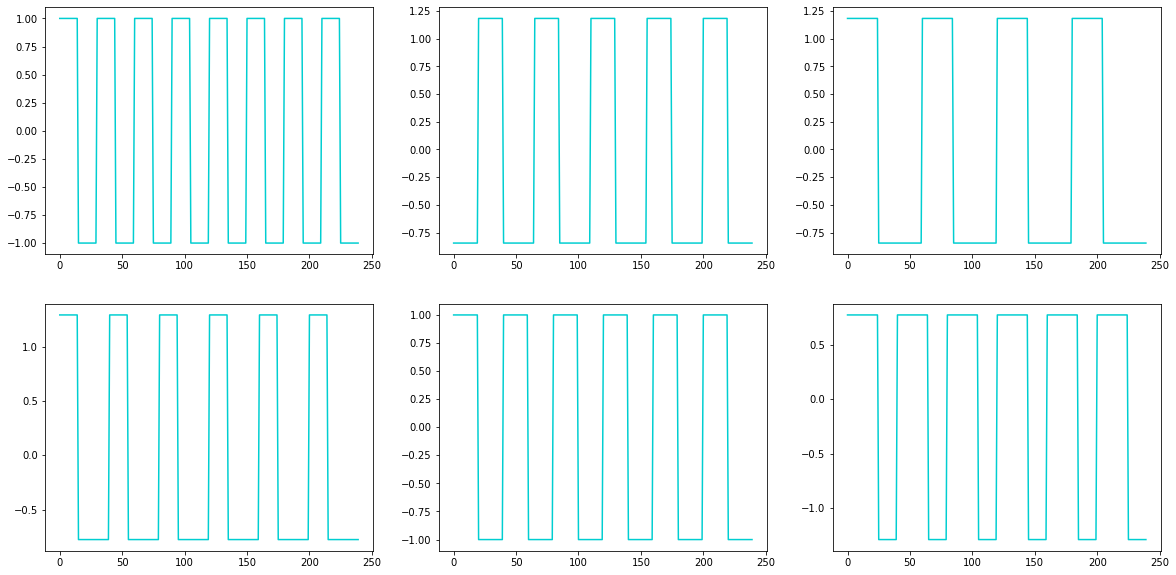

In [5]:
# plotting the graphs
x = range(N)
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(20)
TCcolor = "darkturquoise"

for i in range(nsrcs):
    ax = fig.add_subplot(231+i) 
    ax.plot(x, TCLNormalised[i], color = TCcolor)
plt.show()

1.2

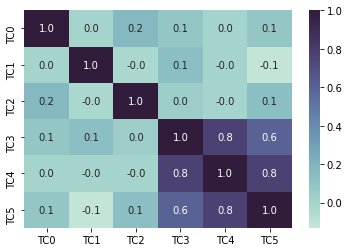

In [6]:
# plot correlation matrix for TC data
TCdf = pd.DataFrame(TC, columns = ["TC0", "TC1", "TC2", "TC3", "TC4", "TC5"])
corr_mat = TCdf.corr()
TCcmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sns.heatmap(corr_mat, cmap=TCcmap, annot = True, fmt='.1f')

plt.show()

1.3

In [7]:
# create SM data
def createSM(vs, hs):
    SM = np.zeros((x1, x2), dtype=int)
    for i in range(x1):
        for j in range(x2):
            if i in range(hs[0], hs[1]) and j in range(vs[0], vs[1]):
                SM[i][j] = 1
    return SM

tmpSM = []
tmpSM.append(createSM([2, 6], [2,6]))
tmpSM.append(createSM([2, 6], [15, 19]))
tmpSM.append(createSM([8, 13], [2, 6]))
tmpSM.append(createSM([8, 13], [15, 19]))
tmpSM.append(createSM([15, 19], [2, 6]))
tmpSM.append(createSM([15, 19], [15, 19]))

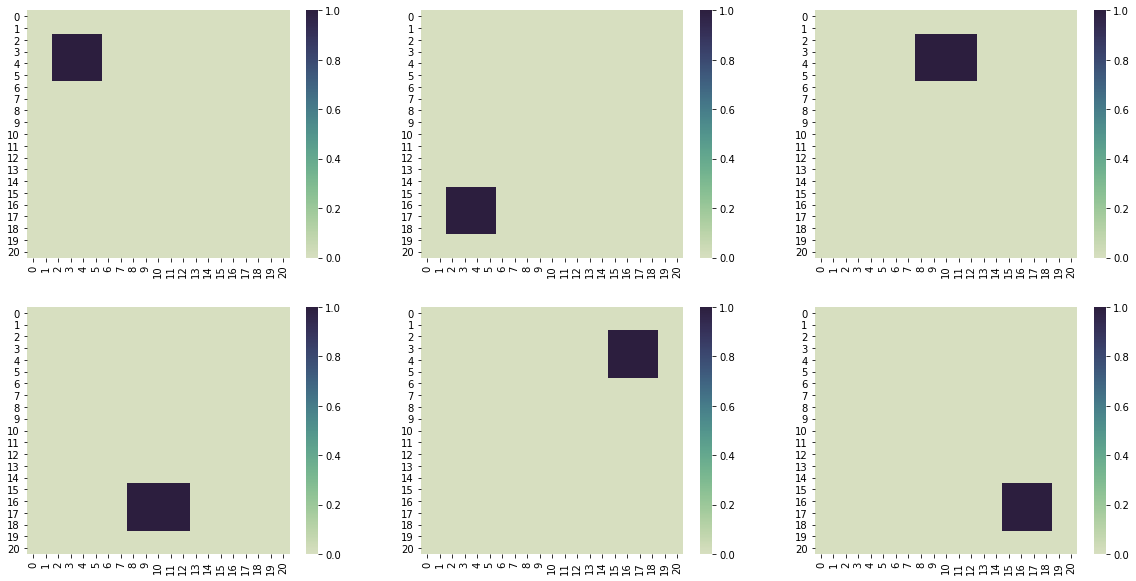

In [8]:
SMcmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(20)
plt.xlim=(0,22)
plt.ylim=(0,22)

for i in range(nsrcs):
    ax = fig.add_subplot(231+i) 
    sns.heatmap(tmpSM[i], cmap=SMcmap)
plt.show()

In [9]:
# flatten each small SM matrix to create final SM
SM = []
for i in range(nsrcs):
    SM.append(tmpSM[i].flatten())
SM = np.asmatrix(SM)

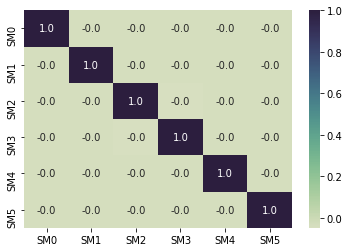

In [10]:
# plot correlation matrix for SM data
SMdf = pd.DataFrame(SM.transpose(), columns = ["SM0", "SM1", "SM2", "SM3", "SM4", "SM5"])
corr_mat = SMdf.corr()
sns.heatmap(corr_mat, cmap=SMcmap, annot = True, fmt='.1f')

plt.show()

1.4

In [11]:
# generate white Gaussian noise for TC and SM
mu = 0
varTC = 0.25
varSM = 0.015
TCnoise = np.random.normal(mu, math.sqrt(varTC), size = N*nsrcs)
GammaTC = TCnoise.reshape(240,6)
SMnoise = np.random.normal(mu, math.sqrt(varSM), size = nsrcs*V)
GammaSM = SMnoise.reshape(6, 441)

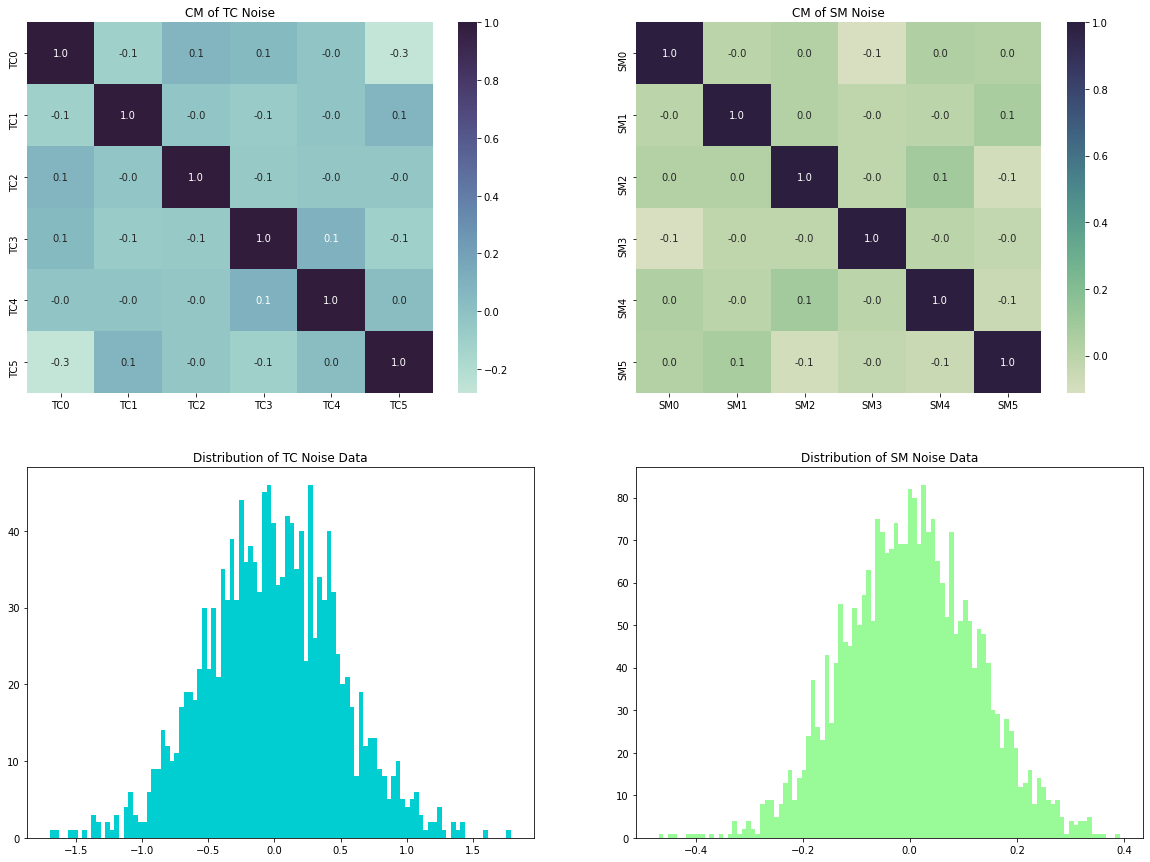

In [12]:
# plot correlation matrix for TC and SM noise
GammaTCdf = pd.DataFrame(GammaTC, columns = ["TC0", "TC1", "TC2", "TC3", "TC4", "TC5"])
GammaTCcorr_mat = GammaTCdf.corr()
GammaSMdf = pd.DataFrame(GammaSM.transpose(), columns = ["SM0", "SM1", "SM2", "SM3", "SM4", "SM5"])
GammaSMcorr_mat = GammaSMdf.corr()

fig, axes = plt.subplots(2, 2) 
fig.set_figheight(15)
fig.set_figwidth(20)



sns.heatmap(GammaTCcorr_mat, cmap=TCcmap, annot = True, fmt='.1f', ax = axes[0][0])
axes[0][0].set_title("CM of TC Noise")
sns.heatmap(GammaSMcorr_mat, cmap=SMcmap, annot = True, fmt='.1f', ax = axes[0][1])
axes[0][1].set_title("CM of SM Noise")
axes[1][0].hist(TCnoise, bins=100, color = "darkturquoise")
axes[1][0].set_title("Distribution of TC Noise Data")
axes[1][1].hist(SMnoise, bins=100, color = "palegreen")
axes[1][1].set_title("Distribution of SM Noise Data")

plt.show()

In [13]:
GammaTCSM = np.matmul(GammaTC, GammaSM)

1.5

In [14]:
X = np.matmul(GammaTC + TC, GammaSM + SM)
TCGammaSM = np.matmul(TC, GammaSM)
SMGammaTC = np.matmul(GammaTC, SM)
print(X.shape)

(240, 441)


In [15]:
sampleX = random.sample(range(0, V), 100)
sampleXdf = pd.DataFrame(np.take(X, sampleX, 1))
sampleXdf.to_pickle("SampleX.pkl")

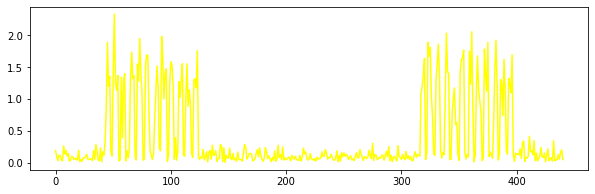

In [16]:
Vvar = []
for i in range(V):
    Vvar.append(X[:, i].var())
fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(10)
plt.plot(Vvar, color = "yellow")
plt.show()
Xst = (X - X.mean())/X.std()
Xstdf = pd.DataFrame(Xst)
Xstdf.to_pickle("Xst.pkl")

Question 2

2.1

In [23]:
# X = DA + E
D = TC 
# estimate A using least square regression
ALSR = np.matmul(np.matmul(np.linalg.inv(np.matmul(D.transpose(),D)),D.transpose()), X) 
print(f"check dim(SM) = dim(ALSR): {ALSR.shape == SM.shape}")
DLSR = np.matmul(X, ALSR.transpose())
print(f"check dim(TC) = dim(DLSR): {DLSR.shape == TC.shape}")

check dim(SM) = dim(ALSR): True
check dim(TC) = dim(DLSR): True


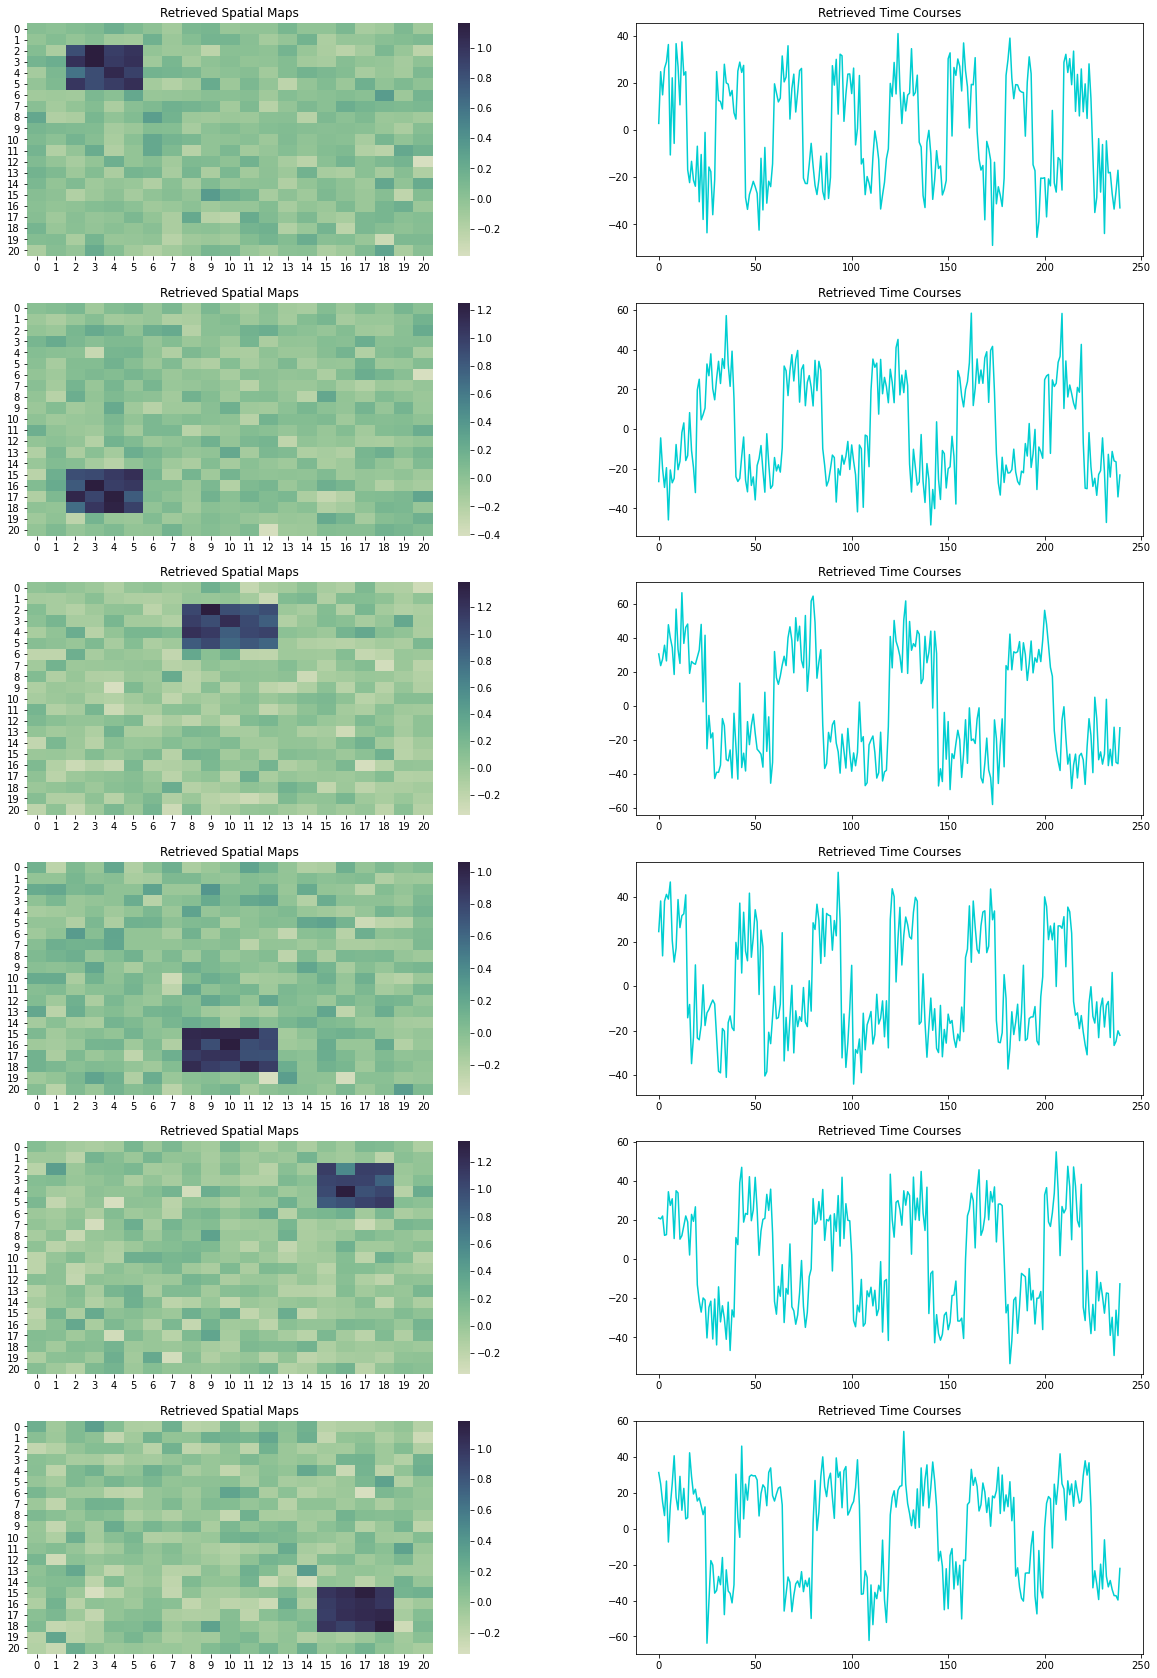

In [54]:
fig, axes = plt.subplots(6, 2) 
fig.set_figheight(30)
fig.set_figwidth(20)


for i in range(nsrcs):
    axes[i][0].set_title("Retrieved Spatial Maps")
    sns.heatmap(ALSR[i].reshape(x1,x2), cmap=SMcmap, ax = axes[i,0])
    axes[i][1].set_title("Retrieved Time Courses")
    axes[i][1].plot(x, DLSR[:, i], color = TCcolor)
    
plt.show()


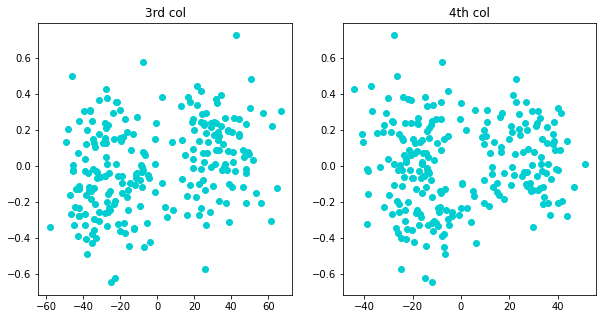

In [66]:
fig, axes = plt.subplots(1, 2) 
fig.set_figheight(5)
fig.set_figwidth(10)

axes[0].set_title("3rd col")
axes[0].scatter([DLSR[:,3-1]], [X[:, 30]], color = TCcolor)
axes[1].set_title("4th col")
axes[1].scatter([DLSR[:,4-1]], [X[:, 30]], color = TCcolor)
plt.show()

2.2

In [ ]:
ARR = 